# ALS applications

## Dzen dataset

Data comes from [dzen.ru](https://dzen.ru/) site and consists of likes which users put to text articles

### Columns
1. item_id - unique id of an item (article)
2. user_id - unique id of a user
3. source_id - unique id of an author. If two items have same source_id, then they come from one author
4. Name of item is name of the article
5. Raw dataset represents user_id and list of item_ids which user liked

In [1]:
#curl -O -J -L 'https://www.dropbox.com/s/ia4bvhuqg8kesee/zen_dataset.zip?dl=1'
#unzip zen_dataset.zip

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import implicit
from scipy.sparse import lil_matrix

from sklearn.metrics.pairwise import cosine_similarity


from tqdm.notebook import tqdm
import ast
import matplotlib.pyplot as plt

from scipy.sparse import diags

In [3]:
item_names = pd.read_csv("zen_item_to_name.csv")
item_sources = pd.read_csv("zen_item_to_source.csv")
dataset = pd.read_csv("zen_ratings.csv", converters={'item_ids': ast.literal_eval})

In [4]:
item_lengths = dataset['item_ids'].apply(len)
total_interactions_count = int(item_lengths.sum())

user_coo = np.repeat(np.arange(len(dataset)), item_lengths).astype(np.int64)
item_coo = np.concatenate(dataset['item_ids'].values).astype(np.int64)

shape = (int(user_coo.max()) + 1, int(item_coo.max()) + 1)
user_item_matrix = sp.coo_matrix(
    (np.ones(total_interactions_count, dtype=np.int64), (user_coo, item_coo)), shape=shape
).tocsr()

del user_coo, item_coo, dataset

In [5]:
item_weights = np.array(user_item_matrix.sum(axis=0)).flatten()
top_to_bottom_order = np.argsort(-item_weights)

item_mapping = np.empty_like(top_to_bottom_order)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = np.sum(item_weights > 0)
total_user_count = user_item_matrix.shape[0]

In [6]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]

This is useful for debugging (just to save time).

**Final answers should use full dataset!!!**

## Split dataset matrix (5 points)

in the following way: for 20% of users (random) remove one like - this will be test data. The rest is train data. (10 points)

In [7]:
def split_data(ratings, test_ratio=0.2):
    ratings = ratings.copy()
    train_matrix = ratings.copy()
    test_matrix = sp.lil_matrix(ratings.shape)

    non_zero_idx = ratings.nonzero()
    non_zero_pairs = list(zip(non_zero_idx[0], non_zero_idx[1]))

    np.random.seed(42)
    np.random.shuffle(non_zero_pairs)

    num_test = int(np.floor(test_ratio * len(non_zero_pairs)))
    for idx in range(num_test):
        user, item = non_zero_pairs[idx]
        test_matrix[user, item] = ratings[user, item]
        train_matrix[user, item] = 0

    train_matrix.eliminate_zeros()
    test_matrix = test_matrix.tocsr()

    return train_matrix, test_matrix

In [8]:
def build_debug_dataset(user_item_matrix, item_pct: float, user_pct: float):
    user_count = int(total_user_count * user_pct), 
    item_count = int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(
        np.arange(user_item_matrix.shape[0]), size=user_count, replace=False
    )
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

debug_dataset = build_debug_dataset(user_item_matrix, 0.05, 0.05) # use of 5% of dataset

In [9]:
# train_ratings, test_ratings = split_data(user_item_matrix)
train_ratings, test_ratings = split_data(debug_dataset) # too long to wait in another way

## Implement ALS, IALS (10 points each)

Note that due to size of data you need to implement algorithms with _sparce matrices_!

In [10]:
def calc_oposite_vectors(Y, A):
    B = Y.T.dot(Y) + lam * np.eye(k)
    C = A.dot(Y)
    return np.linalg.inv(B).dot(C.T).T

def eig_values(Q):
    return np.linalg.eigh(Q)[0]

def eig_vectors(Q):
    return np.linalg.eigh(Q)[1]

In [11]:
def als(ratings, k=10, lam=1e-4, iterations=10):
    n_users, n_items = ratings.shape
    user_embeddings = np.random.randn(n_users, k)
    item_embeddings = np.random.randn(n_items, k)

    for _ in tqdm(range(iterations)):
        for user in range(n_users):
            rated_items = ratings[user, :].nonzero()[1]
            if rated_items.size == 0:
                continue

            Q = item_embeddings[rated_items, :]
            R = ratings[user, rated_items].toarray()
            A = Q.T @ Q + lam * np.eye(k)
            b = Q.T @ R.T
            user_embeddings[user] = np.linalg.solve(A, b).ravel()

        for item in range(n_items):
            rated_by_users = ratings[:, item].nonzero()[0]
            if rated_by_users.size == 0:
                continue

            P = user_embeddings[rated_by_users, :]
            R = ratings[rated_by_users, item].T.toarray()
            A = P.T @ P + lam * np.eye(k)
            b = P.T @ R.T
            item_embeddings[item] = np.linalg.solve(A, b).ravel()

    return user_embeddings, item_embeddings

In [12]:
def ials(ratings, k=10, lam=1e-4, iterations=10, alpha=1e4):
    n_users, n_items = ratings.shape
    user_embeddings = np.random.randn(n_users, k)
    item_embeddings = np.random.randn(n_items, k)

    lambda_eye = lam * np.eye(k)
    C = ratings.copy()
    C.data = 1 + alpha * C.data
    C = C.tocsr() 

    for _ in tqdm(range(iterations)):
        for user in range(n_users):
            Cu = sp.diags(C[user].toarray().flatten())
            Pu = ratings[user].toarray().flatten()
            YTCuY = item_embeddings.T @ Cu @ item_embeddings + lambda_eye
            YTCuPu = item_embeddings.T @ (Cu @ Pu[:, None])

            user_embeddings[user, :] = np.linalg.solve(YTCuY, YTCuPu).ravel()

        for item in range(n_items):
            Ci = sp.diags(C[:, item].toarray().flatten())
            Pi = ratings[:, item].toarray().flatten()
            XTCiX = user_embeddings.T @ Ci @ user_embeddings + lambda_eye
            XTCiPi = user_embeddings.T @ (Ci @ Pi[:, None])

            item_embeddings[item, :] = np.linalg.solve(XTCiX, XTCiPi).ravel()

    return user_embeddings, item_embeddings

## Compute MRR@100 metric for test users (10 points)

In [13]:
def mmr(predictions, test_ratings, k=100):
    mrr_sum = 0.0
    num_users = test_ratings.shape[0]

    for user in range(num_users):
        pred_indices = predictions[user].indices
        pred_data = predictions[user].data
        if len(pred_data) == 0:
            continue

        top_k_indices = np.argsort(-pred_data)[:k]
        relevant_items = test_ratings[user].indices
        rank = k + 1
        for idx in top_k_indices:
            if pred_indices[idx] in relevant_items:
                rank = np.where(top_k_indices == idx)[0][0] + 1
                break
        if rank <= k:
            mrr_sum += 1.0 / rank

    mrr_value = mrr_sum / num_users
    return mrr_value

In [14]:
def get_predictions_sparse_matrix(user_embeddings, item_embeddings):
    predictions_dense_matrix = np.dot(user_embeddings, item_embeddings.T)
    predictions_sparse_matrix = sp.csr_matrix(predictions_dense_matrix)
    return predictions_sparse_matrix

In [15]:
# ALS
user_embeddings, item_embeddings = als(train_ratings)
als_predictions = get_predictions_sparse_matrix(user_embeddings, item_embeddings)
mrr_als = mmr(als_predictions, test_ratings)
print(f"MRR@100 for ALS: {mrr_als}")

  0%|          | 0/10 [00:00<?, ?it/s]

MRR@100 for ALS: 0.004222904538794399


In [16]:
# IALS
user_embeddings, item_embeddings = ials(train_ratings)
ials_predictions = get_predictions_sparse_matrix(user_embeddings, item_embeddings)
mrr_ials = mmr(ials_predictions, test_ratings)
print(f"MRR@100 for IALS: {mrr_ials}")

  0%|          | 0/10 [00:00<?, ?it/s]

MRR@100 for IALS: 0.0036118869915505503


## Adjust hyperparameters of ALS and IALS to maximize MRR (20 points)

Main hyperparameters are regularization and weights for implicit case.

In [18]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt

In [17]:
als_study = None
ials_study = None

In [23]:
def train_als_model(k, lam, iterations):
    user_embeddings, item_embeddings = als(train_ratings, k, lam, iterations)
    als_predictions = get_predictions_sparse_matrix(user_embeddings, item_embeddings)
    return mmr(als_predictions, test_ratings)

def train_ials_model(k, lam, iterations, alpha):
    user_embeddings, item_embeddings = ials(train_ratings, k, lam, iterations, alpha)
    ials_predictions = get_predictions_sparse_matrix(user_embeddings, item_embeddings)
    return mmr(ials_predictions, test_ratings)

def als_objective(trial):
    k = trial.suggest_int('k', 10, 50, step=20)
    lam = trial.suggest_loguniform('lam', 1e-4, 1e-2)
    iterations = 3  # fixed value for iterations
    # iterations = trial.suggest_int('iterations', 3, 5, step=2)
    mrr = train_als_model(k, lam, iterations)
    return -mrr 

def ials_objective(trial):
    k = trial.suggest_int('k', 10, 50, step=20)
    lam = trial.suggest_loguniform('lam', 1e-4, 1e-3)
    iterations = 3  # fixed value for iterations
    # iterations = trial.suggest_int('iterations', 3, 5, step=2)
    alpha = trial.suggest_int('alpha', 10, 100, step=45)
    mrr = train_ials_model(k, lam, iterations, alpha)
    return -mrr

def optimize_als():
    global als_study
    pruner = optuna.pruners.HyperbandPruner()
    # pruner = optuna.pruners.SuccessiveHalvingPruner()
    als_study = optuna.create_study(pruner=pruner)
    als_study.optimize(als_objective, n_trials=5)
    print("Best parameters for ALS: ", als_study.best_params)
    plot_optimization_history(als_study)
    plot_param_importances(als_study)
    plt.show()

def optimize_ials():
    global ials_study
    pruner = optuna.pruners.HyperbandPruner()
    # pruner = optuna.pruners.SuccessiveHalvingPruner()
    ials_study = optuna.create_study(pruner=pruner)
    ials_study.optimize(ials_objective, n_trials=5)
    print("Best parameters for IALS: ", ials_study.best_params)
    plot_optimization_history(ials_study)
    plot_param_importances(ials_study)
    plt.show()


def plot_additional_visualizations(study):
    optuna.visualization.matplotlib.plot_contour(study)
    plt.show()


In [24]:
optimize_als()

[I 2024-08-28 13:26:23,772] A new study created in memory with name: no-name-4eb54352-530f-4e3b-8e53-54e1528a090f
/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_95161/189476848.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lam = trial.suggest_loguniform('lam', 1e-4, 1e-2)


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:33:22,340] Trial 0 finished with value: -0.016256819878311898 and parameters: {'k': 50, 'lam': 0.00012330839298204272}. Best is trial 0 with value: -0.016256819878311898.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:36:15,732] Trial 1 finished with value: -0.008867539504649344 and parameters: {'k': 30, 'lam': 0.00032021548982100515}. Best is trial 0 with value: -0.016256819878311898.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:36:23,604] Trial 2 finished with value: -0.0032687586207191593 and parameters: {'k': 10, 'lam': 0.0004821507464042217}. Best is trial 0 with value: -0.016256819878311898.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:42:31,912] Trial 3 finished with value: -0.018502508230195034 and parameters: {'k': 50, 'lam': 0.0010606757337168363}. Best is trial 3 with value: -0.018502508230195034.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:42:40,327] Trial 4 finished with value: -0.0041018280211298185 and parameters: {'k': 10, 'lam': 0.0006907215428547915}. Best is trial 3 with value: -0.018502508230195034.


Best parameters for ALS:  {'k': 50, 'lam': 0.0010606757337168363}


In [25]:
optimize_ials()

[I 2024-08-28 13:57:49,090] A new study created in memory with name: no-name-d913f297-4443-4cf2-8f2f-9ff5aafdae79
/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_95161/189476848.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 13:58:10,766] Trial 0 finished with value: -0.004310987393061759 and parameters: {'k': 10, 'lam': 0.00022842405188083531, 'alpha': 10}. Best is trial 0 with value: -0.004310987393061759.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 14:57:14,820] Trial 1 finished with value: -0.009029254139814697 and parameters: {'k': 30, 'lam': 0.00033900731268386806, 'alpha': 55}. Best is trial 1 with value: -0.009029254139814697.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 15:45:23,181] Trial 2 finished with value: -0.01013517889814887 and parameters: {'k': 30, 'lam': 0.0007893735712959494, 'alpha': 10}. Best is trial 2 with value: -0.01013517889814887.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 15:45:51,374] Trial 3 finished with value: -0.00452911201506452 and parameters: {'k': 10, 'lam': 0.0009542710593329046, 'alpha': 10}. Best is trial 2 with value: -0.01013517889814887.


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-08-28 15:46:16,695] Trial 4 finished with value: -0.003208204582043462 and parameters: {'k': 10, 'lam': 0.00023487078507579716, 'alpha': 100}. Best is trial 2 with value: -0.01013517889814887.


Best parameters for IALS:  {'k': 30, 'lam': 0.0007893735712959494, 'alpha': 10}


/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_95161/189476848.py:52: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2024-08-28 15:46:16,760] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


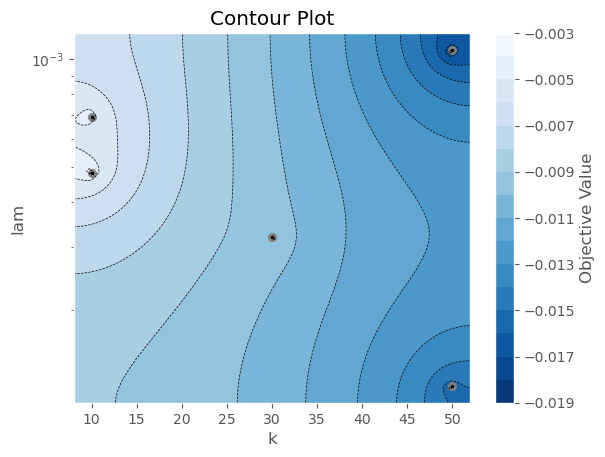

In [26]:
plot_additional_visualizations(als_study)

/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_95161/189476848.py:52: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2024-08-28 15:46:17,347] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


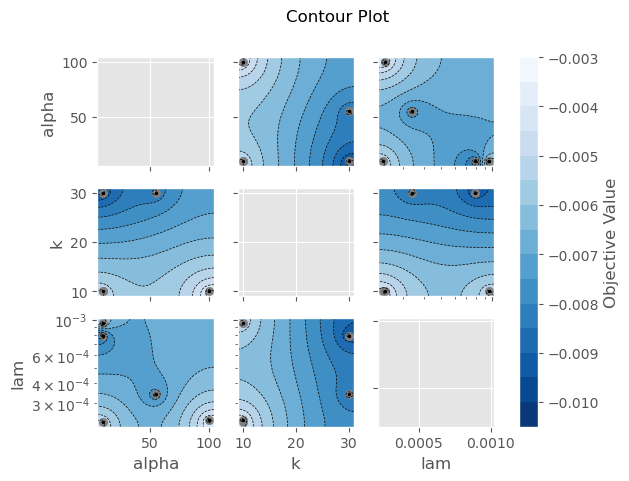

In [27]:
plot_additional_visualizations(ials_study)

## Get similarities from item2item CF and SLIM (10 points each)

Item2item can be taken from the first homework, SLIM was implemented in the class.

Alternatively you could use libraries, but in this case you will need to convert dataset to their format.

You need to compute only item similarities, not predictions for users.

In [29]:
item_user_matrix = user_item_matrix.T
i2i_similarity = cosine_similarity(item_user_matrix, dense_output=False)

In [30]:
model = implicit.nearest_neighbours.CosineRecommender()
model.fit(item_user_matrix)

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning:

Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.028472900390625 seconds



  0%|          | 0/75910 [00:00<?, ?it/s]

In [31]:
n_items = item_embeddings.shape[0]
slim_similarity = lil_matrix((n_items, n_items))

for i in range(n_items):
    similarities = cosine_similarity(item_embeddings[i].reshape(1, -1), item_embeddings).flatten()
    top_indices = np.argsort(-similarities)[:10]
    slim_similarity[i, top_indices] = similarities[top_indices]

slim_similarity = slim_similarity.tocsr()

## Compare similarities from four algorithms (20 points)

* plot distributions
* compute metrics (which you think are relevant)
* look at several top similar lists

Make conclusion how these methods differ in computing similarities

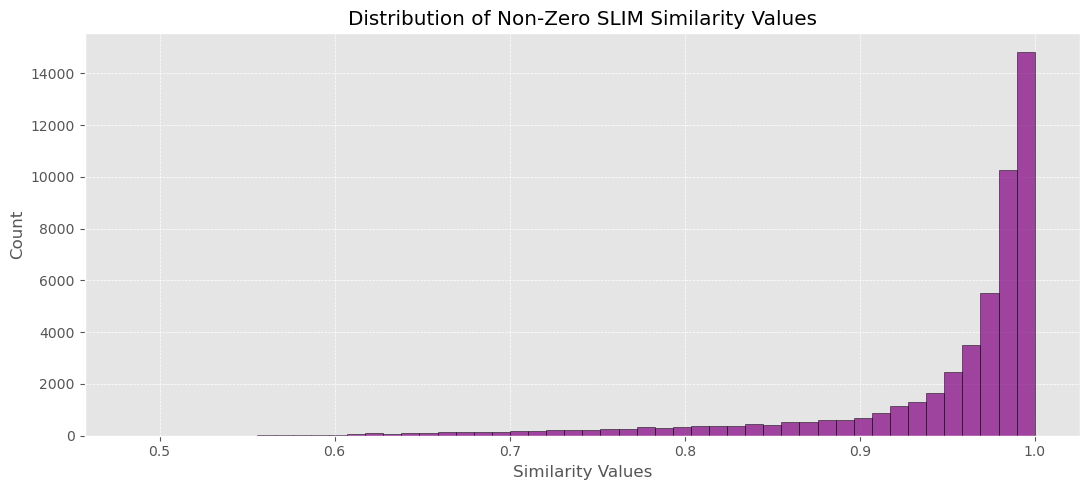

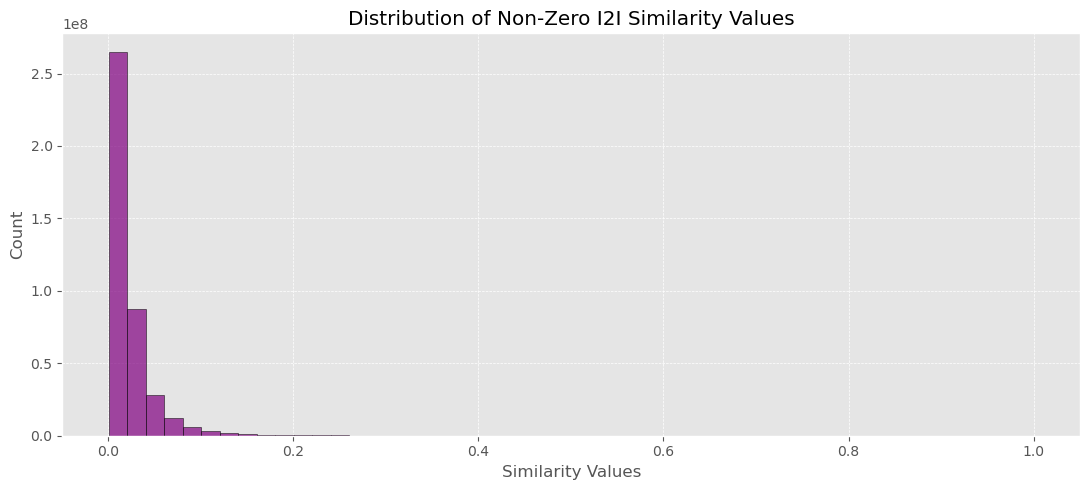

In [33]:
def plot_similarity_distribution(similarity_data, title, color='purple'):
    plt.figure(figsize=(11, 5))
    plt.hist(similarity_data, bins=50, color=color, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Similarity Values')
    plt.ylabel('Count')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

slim_non_zero_values = slim_similarity.data
plot_similarity_distribution(slim_non_zero_values, 'Distribution of Non-Zero SLIM Similarity Values')

i2i_non_zero_values = i2i_similarity.data
plot_similarity_distribution(i2i_non_zero_values, 'Distribution of Non-Zero I2I Similarity Values')